# Time Series Forecasting with Python 7-Day Mini-Course
Ref: https://machinelearningmastery.com/time-series-forecasting-python-mini-course/

Using the ml env.

Later addition:
    Found this incredibly helpful resource on medium:
    https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [54]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url, header=0, index_col=0)
data.asfreq(freq='D')
data.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


Note that the date is the index in the above dataset. This is common for time series data.

In [55]:
data.describe(include='all')

,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


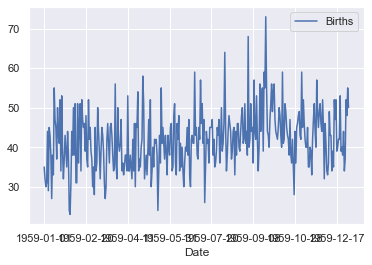

In [56]:
data.plot()
plt.show()

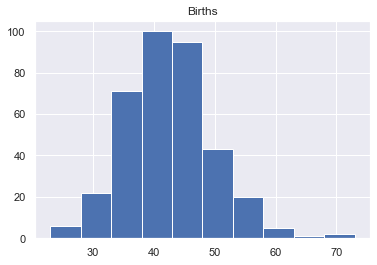

In [57]:
data.hist()
plt.show()

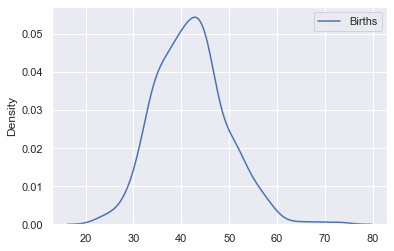

In [58]:
# Density plot (KDE = kernel density estimate)
sns.kdeplot(data=data)
plt.show()

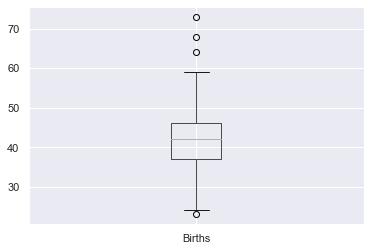

In [59]:
data.boxplot()
plt.show()

### Persistence Forecast Model
The simplest forecast you can make is the current observation ($t$) to predict the observation at the next time step ($t+1$).

This is called the **naive forecast** or the persistence forecast and may be the best possible model on some time series forecast problems (how vague is that??).

In [60]:
import sklearn.metrics as metrics
import numpy as np

In [61]:
def regression_results(y_true, y_pred):
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("Explained Variance: ", round(explained_variance, 4))
    print("Mean Squared Log Error: ", round(mean_squared_log_error, 4))
    print("R2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mean_squared_error, 4))
    print("RMSE: ", round(np.sqrt(mean_squared_error), 4))

## Training and test sets
I'll include this from the medium article since I find the methodology interesting, and it makes sense looking at it.

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
train, test = train_test_split(data,
    test_size=0.2,
    shuffle=False) # Preserves order

print(train.tail(), test.head())

            Births
Date              
1959-10-15      42
1959-10-16      51
1959-10-17      49
1959-10-18      45
1959-10-19      43             Births
Date              
1959-10-20      42
1959-10-21      38
1959-10-22      47
1959-10-23      38
1959-10-24      36


In [64]:
train['t-1'] = train.loc[:,'Births'].shift(1)
train = train.dropna()

true = train['Births']
pred = train['t-1']

error = np.sqrt(metrics.mean_squared_error(true, pred))
print(f"Test RMSE: {error:.3f}")

Test RMSE: 9.512


So our baseline MSE is $9.512$.

In [65]:
from statsmodels.tsa.ar_model import AutoReg

## AutoReg

In [66]:
model = AutoReg(train['t-1'], lags=2)
model_fit = model.fit()

C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [67]:
coef = model_fit.params
history = train['Births'].values
pred = []
for t in test.values:
    length = len(history)
    lag = [history[j] for j in range(length-2, length)]
    yhat = coef[0]
    for k in range(2):
        yhat += coef[k+1] * lag[2-k-1]
    pred.append(yhat)
    history = np.append(history, t)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(metrics.mean_squared_error(test, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.228


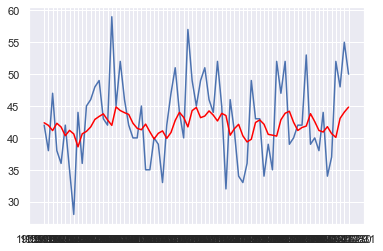

In [68]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

In [69]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller

## ARIMA

In [70]:
result = adfuller(train['Births'].values)
print(f"ADF Stat: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: ")
for key, value, in result[4].items():
    print(f"{key}: {value}")

ADF Stat: -3.4017564819190986
p-value: 0.010899138802792892
Critical Values: 
1%: -3.453670163592738
5%: -2.8718077069772248
10%: -2.5722411158835796


Since the p-value is less than 0.05 & the ADF stat is less than/super close to the critical values suggest that the time series is stationary. Since the time series data is stationary, we'll set the $d$ parameter to 0.

In [71]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

Hurst exponent shows the trend of the data.

$H>0.5$ means it's trending

$H=0.5$ shows random walk/Brownian motion

$H<0.5$ means it's mean-reverting (stationary)

20 lags is what's used in Matplotlib's implementation.

In [72]:
hurst_exp = get_hurst_exponent(train['Births'].values)
print(f"Hurst exponent with 20 lags: {hurst_exp:.3f}")

Hurst exponent with 20 lags: 0.019


Supporting evidence that our data is stationary!

In [73]:
model = ARIMA(train['Births'], order=(2,0,2))
model_fit:ARIMAResults = model.fit()
model_fit.summary()

C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                  291
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -983.722
Date:                Tue, 26 Apr 2022   AIC                           1979.445
Time:                        18:57:35   BIC                           2001.485
Sample:                    01-02-1959   HQIC                          1988.274
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.3114      4.365      9.693      0.000      33.756      50.867
ar.L1          0.0232      0.034      0.682      0.495      -0.043       0.090
ar.L2          0.9637      0.034     28.706      0.000       0.898       1.029
ma.L1          0.0535      1.607      0.033      0.973      -3.096       3.203
ma.L2         -0.9463      1.519     -0.623      0.533      -3.924       2.031
sigma2        50.1082     79.211      0.633      0.527    -105.143     205.360
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                23.44
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.57
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

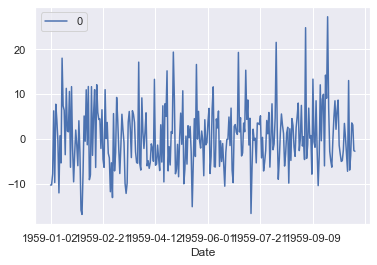

In [74]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

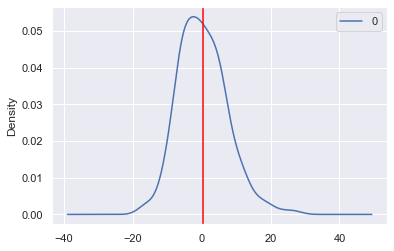

In [75]:
residuals.plot(kind="kde")
plt.axvline(residuals[0].mean(), color="red")
plt.show()

In [94]:
# better way of writing the code, as opposed to above in AutoReg
history = train['Births'].values
predictions = []
for t in test.values:
    model = ARIMA(history, order=(2,0,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history = np.append(history, t) # have to use np because it's an ndarray
    # print('predicted=%f, expected=%f' % (yhat, t))
rmse = np.sqrt(metrics.mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gamet\anaconda3\envs\ml\

Test RMSE: 6.595


C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


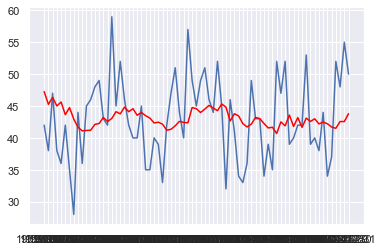

In [95]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Results
Baseline persistence model RMSE: $9.512$

AutoReg model RMSE: $6.228$

ARIMA model RMSE: $6.595$

So we did perform a bit better than our baseline, and we likely could've improved more if we standardized our data. One thing I want to point out is the AutoReg model inching beyond the ARIMA model. Since ARIMA is more often used to handle higher AR values (ours was only 2), AutoReg is a perfectly reasonable solution. Complex doesn't mean better!